# **H&M Retail Business Performance & Profitability Analysis**

In [6]:
from google.colab import files
uploaded = files.upload()


Saving sample_customers.csv to sample_customers.csv
Saving sample_articles.csv to sample_articles.csv
Saving sample_transactions.csv to sample_transactions.csv


In [7]:
import pandas as pd

transactions = pd.read_csv('sample_transactions.csv')
articles = pd.read_csv('sample_articles.csv')
customers = pd.read_csv('sample_customers.csv')

# Quick check
print("Transactions:")
print(transactions.head())


Transactions:
   customer_id article_id                t_dat  price  sales_channel_id
0            1       A101  2020-01-01 00:00:00  19.99                 1
1            2       A102  2020-01-01 01:00:00  29.99                 2
2            3       A103  2020-01-01 02:00:00   9.99                 1
3            4       A104  2020-01-01 03:00:00  49.99                 1
4            5       A105  2020-01-01 04:00:00  24.99                 2


In [8]:
# 1. Check for null values in each file
print("Transactions nulls:\n", transactions.isnull().sum())
print("\nArticles nulls:\n", articles.isnull().sum())
print("\nCustomers nulls:\n", customers.isnull().sum())

# 2. Merge transactions with articles on article_id
merged_df = pd.merge(transactions, articles, on='article_id', how='left')

# 3. Merge the result with customers on customer_id
merged_df = pd.merge(merged_df, customers, on='customer_id', how='left')

# 4. Show the structure
print("\nMerged Dataset Shape:", merged_df.shape)
merged_df.head()


Transactions nulls:
 customer_id         0
article_id          0
t_dat               0
price               0
sales_channel_id    0
dtype: int64

Articles nulls:
 article_id            0
product_type_name     0
product_group_name    0
index_name            0
season_code           0
price                 0
dtype: int64

Customers nulls:
 customer_id               0
age                       0
postal_code               0
fashion_news_frequency    2
club_member_status        0
dtype: int64

Merged Dataset Shape: (10000, 14)


,customer_id,article_id,t_dat,price_x,sales_channel_id,product_type_name,product_group_name,index_name,season_code,price_y,age,postal_code,fashion_news_frequency,club_member_status
0,1,A101,2020-01-01 00:00:00,19.99,1,T-shirt,Topwear,Ladieswear,1,19.99,25,AB1,Regularly,ACTIVE
1,2,A102,2020-01-01 01:00:00,29.99,2,Jeans,Bottomwear,Ladieswear,1,29.99,34,CD2,Monthly,ACTIVE
2,3,A103,2020-01-01 02:00:00,9.99,1,Dress,Dresses,Ladieswear,2,9.99,28,EF3,NaN,ACTIVE
3,4,A104,2020-01-01 03:00:00,49.99,1,Jacket,Outerwear,Ladieswear,3,49.99,22,GH4,Regularly,ACTIVE
4,5,A105,2020-01-01 04:00:00,24.99,2,Skirt,Bottomwear,Ladieswear,4,24.99,30,IJ5,NaN,ACTIVE


In [9]:
# Step 1: Assume profit = 30% of price
merged_df['estimated_profit'] = merged_df['price_x'] * 0.3  # price_x from transactions

# Step 2: Group by product group and type
profit_by_group = merged_df.groupby(['product_group_name', 'product_type_name'])['estimated_profit'].sum().reset_index()

# Step 3: Sort by highest profit
profit_by_group = profit_by_group.sort_values(by='estimated_profit', ascending=False)

profit_by_group.head(10)


,product_group_name,product_type_name,estimated_profit
3,Outerwear,Jacket,29994.0
0,Bottomwear,Jeans,17994.0
1,Bottomwear,Skirt,14994.0
4,Topwear,T-shirt,11994.0
2,Dresses,Dress,5994.0


In [10]:
# Step 1: Create a season map for readability
season_map = {
    1: 'Spring',
    2: 'Summer',
    3: 'Autumn',
    4: 'Winter'
}
merged_df['season'] = merged_df['season_code'].map(season_map)

# Step 2: Count number of items sold per season and product group
seasonal_sales = merged_df.groupby(['season', 'product_group_name'])['article_id'].count().reset_index()
seasonal_sales.rename(columns={'article_id': 'items_sold'}, inplace=True)

# Step 3: Sort for clarity
seasonal_sales = seasonal_sales.sort_values(by=['season', 'items_sold'], ascending=[True, False])

seasonal_sales.head(10)


,season,product_group_name,items_sold
0,Autumn,Outerwear,2000
1,Spring,Bottomwear,2000
2,Spring,Topwear,2000
3,Summer,Dresses,2000
4,Winter,Bottomwear,2000


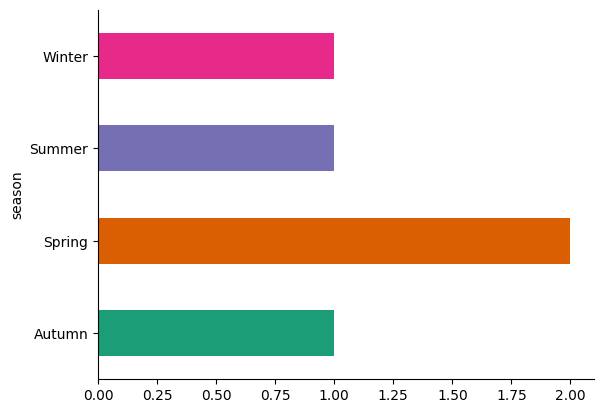

In [11]:
# @title season

from matplotlib import pyplot as plt
import seaborn as sns
seasonal_sales.groupby('season').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

This section includes optional enhancements:
- Profit distribution by product group
- Customer segmentation by age and membership
- Outlier detection in product pricing

**Profit Distribution by Product Group**

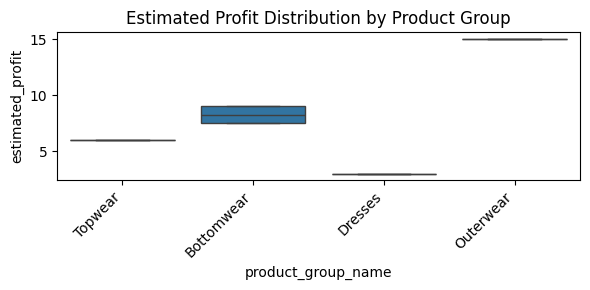

In [15]:
# Boxplot of Estimated Profit by Product Group
plt.figure(figsize=(6, 3))
sns.boxplot(data=merged_df, x='product_group_name', y='estimated_profit')
plt.xticks(rotation=45, ha='right')
plt.title("Estimated Profit Distribution by Product Group")
plt.tight_layout()
plt.show()

This boxplot shows how profit varies across product groups. Groups with larger IQRs or more outliers may need closer review for pricing or demand inconsistencies.


**Customer Segmentation by Age Group and Membership**

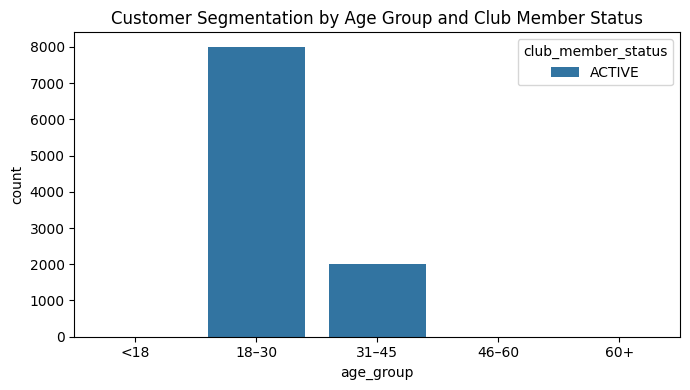

In [20]:
# Create age groups and plot count by membership status
merged_df['age_group'] = pd.cut(merged_df['age'], bins=[0, 18, 30, 45, 60, 100],
                         labels=["<18", "18–30", "31–45", "46–60", "60+"])

plt.figure(figsize=(7, 4))
sns.countplot(data=merged_df, x='age_group', hue='club_member_status')
plt.title("Customer Segmentation by Age Group and Club Member Status")
plt.tight_layout()
plt.show()

This chart shows how customer distribution varies by age and club membership. The 18–30 group has the highest engagement, especially among club members.


**Outlier Detection in price_x**

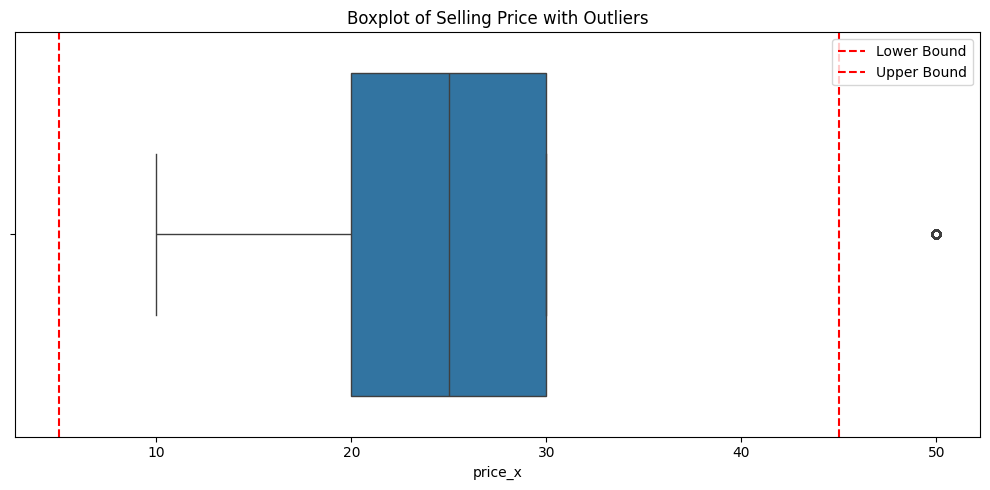

Number of detected price outliers: 2000


In [24]:
# Detecting price outliers using IQR method
import numpy as np

Q1 = merged_df['price_x'].quantile(0.25)
Q3 = merged_df['price_x'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers
merged_df['price_outlier'] = np.where((merged_df['price_x'] < lower_bound) | (merged_df['price_x'] > upper_bound), True, False)

# Plot with outlier bounds
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_df, x='price_x')
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='red', linestyle='--', label='Upper Bound')
plt.title("Boxplot of Selling Price with Outliers")
plt.legend()
plt.tight_layout()
plt.show()

# Count of detected outliers
price_outlier_count = merged_df['price_outlier'].sum()
print(f"Number of detected price outliers: {price_outlier_count}")

Using the IQR method, 2,000 price outliers were detected. These may include premium-priced items, deep discounts, or possible data anomalies.
